# Objectives:

1. Take top 2000 or 3000 features from tf-idf vectorizers using idf_ score.
2. calculate the co-occurrence matrix with the selected features.
3. Choose the n_components in truncated svd, with maximum explained
   variance. 
4. After you are done with the truncated svd, you can apply K-Means clustering and choose
   the best number of clusters based on elbow method.
5. You need to write a function that takes a word and returns the most similar words using
   cosine similarity between the vectors(vector: a row in the matrix after truncatedSVD)

In [177]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import re
import gensim
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

In [178]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 
# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'
#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [179]:
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
# sort reviews based on ProductId

In [180]:
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape
# Remove duplicate reviews

(364173, 10)

In [181]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

In [182]:
# find sentences containing HTML tags
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;   

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [183]:
#stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [184]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                s=(sno.stem(cleaned_words.lower())).encode('utf8')
                filtered_sentence.append(s)
                if (final['Score'].values)[i] == 'positive': 
                    all_positive_words.append(s) #list of all words used to describe positive reviews
                if(final['Score'].values)[i] == 'negative':
                    all_negative_words.append(s) #list of all words used to describe negative reviews reviews
            else:
                continue 
    str1 = b" ".join(filtered_sentence) #final string of cleaned words    
    final_string.append(str1)
    i+=1

In [185]:
final['CleanedText']=final_string

In [186]:
final = final.sort_values(['Time'], ascending=[True])
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'this witti littl book make son laugh loud re...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'can rememb see the show when air televis yea...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth about e...
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",b'twist rumplestiskin captur film star michael...
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,b'beetlejuic excel and funni movi keaton hilar...


In [187]:
final = final.tail(100000)
X = final['CleanedText']

In [188]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,1), stop_words='english', min_df=2)
final_tf_idf = tf_idf_vect.fit_transform(X)

# Select Top 2000 words based on IDF_ score

In [189]:
top_words = []
count = 0
for i,j in sorted(zip(tf_idf_vect.get_feature_names(),tf_idf_vect.idf_), key=lambda x: x[1], reverse=True):
    if count != 2000:
        top_words.append(i)
        count += 1

In [190]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

In [191]:
from progressbar import ProgressBar
pbar = ProgressBar()

In [192]:
sen1 = []
for i in final['CleanedText']:
    word1 = []
    for j in i.decode().split(" "):
        if j not in stopwords:
            word1.append(j)
    sen1.append(word1)

# Find the combination of words present in context of withdow size 5

In [193]:
dict1 = {}
for i in top_words:
    for j in sen1:
        if i in j:
            for k,l in enumerate(j):
                try:
                    if l == i:
                        if (i,j[k-2]) not in dict1:
                            dict1[(i,j[k-2])] = 1
                        else:
                            dict1[(i,j[k-2])] += 1
                        if (i,j[k-1]) not in dict1:
                            dict1[(i,j[k-1])] = 1
                        else:
                            dict1[(i,j[k-1])] += 1
                        if (i,j[k+1]) not in dict1:
                            dict1[(i,j[k+1])] = 1
                        else:
                            dict1[(i,j[k+1])] += 1
                        if (i,j[k+2]) not in dict1:
                            dict1[(i,j[k+2])] = 1
                        else:
                            dict1[(i,j[k+2])] += 1
                except:
                    continue

In [194]:
m = np.zeros([2000,2000])

In [138]:
dict1

{('aaf', 'coffe'): 2,
 ('aaf', 'work'): 2,
 ('aaf', 'came'): 2,
 ('aaf', 'across'): 2,
 ('aafco', 'shop'): 1,
 ('aafco', 'around'): 1,
 ('aafco', 'approv'): 1,
 ('aafco', 'holist'): 1,
 ('aafco', 'ingredi'): 1,
 ('aafco', 'fda'): 1,
 ('aafco', 'consid'): 1,
 ('aafco', 'safe'): 1,
 ('abandon', 'kind'): 1,
 ('abandon', 'bar'): 2,
 ('abandon', 'quest'): 1,
 ('abandon', 'snif'): 1,
 ('abandon', 'lick'): 1,
 ('abandon', 'eat'): 1,
 ('abandon', 'shame'): 1,
 ('abbey', 'fruitcak'): 5,
 ('abbey', 'trappist'): 5,
 ('abbey', 'mani'): 1,
 ('abbey', 'year'): 1,
 ('abbey', 'continu'): 1,
 ('abbey', 'come'): 1,
 ('abbey', 'dark'): 1,
 ('abbey', 'moist'): 1,
 ('abbey', 'state'): 1,
 ('abbey', 'monasteri'): 2,
 ('abbey', 'order'): 1,
 ('abdomen', 'stomach'): 1,
 ('abdomen', 'distress'): 1,
 ('abdomen', 'distent'): 1,
 ('abdomen', 'tri'): 1,
 ('abdomen', 'much'): 1,
 ('abdomen', 'pain'): 1,
 ('abdomen', 'month'): 1,
 ('abdomen', 'suffer'): 1,
 ('abdomin', 'nausea'): 1,
 ('abdomin', 'vomit'): 1,
 ('abdo

# Generating co-occurrence matrices

In [195]:
for i,j in dict1.keys():
    if all (x in top_words for x in [i,j]):
        if (i,j) in dict1.keys() and (j,i) in dict1.keys():
            m[top_words.index(i)][top_words.index(j)] = dict1[i,j] + dict1[j,i]
            m[top_words.index(j)][top_words.index(i)] = dict1[i,j] + dict1[j,i]
        elif (i,j) in dict1.keys():
            m[top_words.index(i)][top_words.index(j)] = dict1[i,j]
            m[top_words.index(j)][top_words.index(i)] = dict1[i,j]
        elif (j,i) in dict1.keys():
            m[top_words.index(j)][top_words.index(i)] = dict1[j,i]
            m[top_words.index(i)][top_words.index(j)] = dict1[j,i]


In [196]:
from sklearn.decomposition import TruncatedSVD

In [197]:
tsvd = TruncatedSVD(n_components=1999)
X_tsvd = tsvd.fit(m)

In [198]:
X_tsvd

TruncatedSVD(algorithm='randomized', n_components=1999, n_iter=5,
       random_state=None, tol=0.0)

# Function to find number of components covers 95% of distribution

In [145]:
# Create a function
def select_n_components(var_ratio, goal_var: float) -> int:
    # Set initial variance explained so far
    total_variance = 0.0
    
    # Set initial number of features
    n_components = 0
    
    # For the explained variance of each feature:
    for explained_variance in var_ratio:
        
        # Add the explained variance to the total
        total_variance += explained_variance
        
        # Add one to the number of components
        n_components += 1
        
        # If we reach our goal level of explained variance
        if total_variance >= goal_var:
            # End the loop
            break
            
    # Return the number of components
    return n_components

In [146]:
select_n_components(tsvd.explained_variance_ratio_, 0.95)

396

In [199]:
tsvd = TruncatedSVD(n_components=396)
X_tsvd = tsvd.fit_transform(m)

# Apply K-means clustering

In [200]:
from sklearn.cluster import KMeans
k_means_cost = []
for k in range (1, 30):
 
    # Create a kmeans model on our data, using k clusters.  random_state helps ensure that the algorithm returns the same results each time.
    kmeans_model = KMeans(n_clusters=k, random_state=1, algorithm = 'auto').fit(X_tsvd)

    # These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
    labels = kmeans_model.labels_
    # Sum of distances of samples to their closest cluster center
    k_means_cost.append(kmeans_model.inertia_)

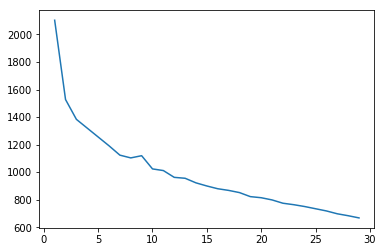

In [201]:
plt.plot(range (1, 30), k_means_cost)

In [217]:
kmeans_model = KMeans(n_clusters=3, init='k-means++', random_state=1, algorithm = 'auto').fit(X_tsvd) 

# Observation:

Only cluster formed is with class label 0. so representing one wordcloud.

In [220]:
len(kmeans_model.labels_)

2000

In [228]:
wordcluster = ' '
for i in top_words:
    wordcluster = wordcluster + i + ' '

In [229]:
cluster0 = WordCloud(width = 800, height = 800,background_color ='white',stopwords = stopwords, min_font_size = 10).generate(wordcluster)  

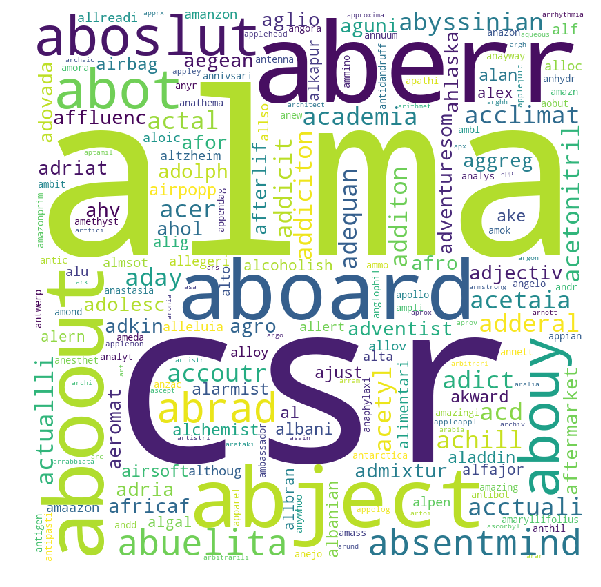

In [230]:
 # plot the WordCloud image                         
plt.figure(figsize = (8, 8), facecolor = None)  
plt.imshow(cluster0)  
plt.axis("off")  
plt.tight_layout(pad = 0)    
plt.show() 

In [152]:
from sklearn.utils.extmath import randomized_svd

In [153]:
U, Sigma, VT = randomized_svd(m, 
                              n_components=396,
                              n_iter=5,
                              random_state=None)

In [154]:
U.shape

(2000, 396)

In [162]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity(U[0].reshape(1,-1), U[400].reshape(1,-1))

array([[-0.01769604]])

# Find similar words using cosine similarity

In [172]:
def find_similar_words(word):
    
    if word in top_words:
        word_index = top_words.index(word)
        for i in range(1999):
            if cosine_similarity(U[word_index].reshape(1,-1), U[i].reshape(1,-1)) > .5 and top_words[i] != word:
                print(top_words[i])
    

In [175]:
find_similar_words('abnorm')

dubious


# END